In [ ]:
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import numpy as np

class QuantumModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = torch.nn.Parameter(torch.randn(5, requires_grad=True))
        print(self.params)
        
        self.dev = qml.device('default.qubit', wires=len(self.params))
        
        @qml.qnode(self.dev, interface='torch')
        def quantum_circuit(params):
            
            for i in range(len(params)): # applies PauliX and Hadamard to all qubits
                qml.PauliX(wires=i)
                qml.Hadamard(wires=i)
            
            for i in range(len(params)-1): # itterates through all except last qubit
                qml.CNOT(wires=[i,i+1])
                qml.RY(params[i], wires=i+1)
            
            qml.CNOT(wires=[len(params)-1, 0]) # handles last qubit
            qml.RY(params[-1], wires=0)
            
            for i in range(len(params)): # applies Hadamard to all qubits
                qml.Hadamard(wires=i)
                
            measurements = [qml.expval(qml.PauliZ(i)) for i in range(len(params))]
            return measurements
        
        self.quantum_circuit = quantum_circuit
    
    def forward(self):
        expvals = self.quantum_circuit(self.params)
        expvals_tensor = torch.stack(expvals)  # stack maintains gradients - don't just make a new tensor
        probs = (1 - expvals_tensor) / 2
        return probs

Parameter containing:
tensor([ 0.1684,  0.8584,  1.0005, -0.7703, -1.7059], requires_grad=True)


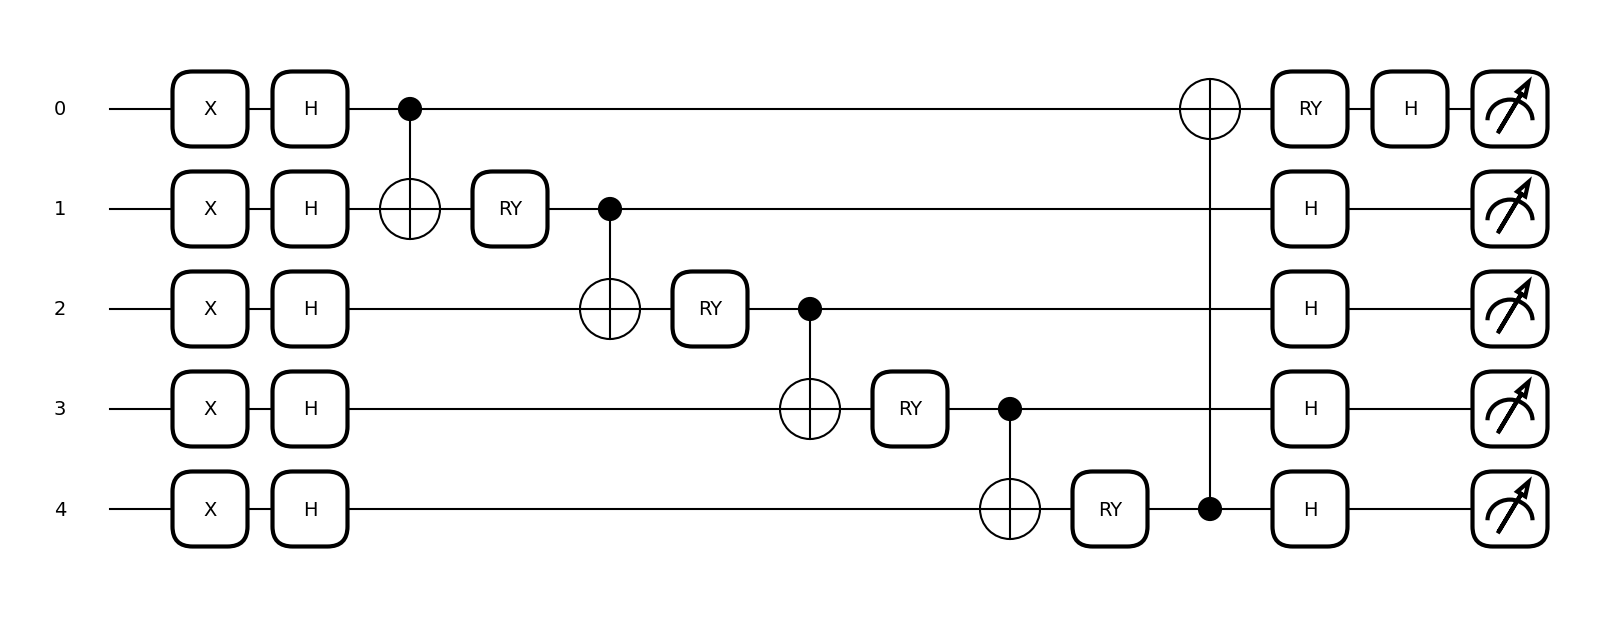

In [22]:
model = QuantumModel()

qml.draw_mpl(model.quantum_circuit)(model.params)
plt.show()

In [23]:
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

target_probs = torch.zeros(len(model.params))
target_probs[1] = 0.3 # choose which output state you want to occur with high probability
target_probs = target_probs.requires_grad_(True)

outputs_before_training = model()


epochs = 100

for epoch in range(epochs):
    optimiser.zero_grad()
    output = model()    
    loss = torch.mean((output - target_probs)**2) # MSE
    loss.backward()
    optimiser.step()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        # print(f"Parameters: {model.params.data}")
        # print(f"First few outputs: {output[:5].detach()}")
        # print("-" * 50)

# print(f"Model Paramater Values: {model.params}")        

Epoch 1, Loss: 0.2456
Epoch 2, Loss: 0.2156
Epoch 3, Loss: 0.1873
Epoch 4, Loss: 0.1607
Epoch 5, Loss: 0.1362
Epoch 6, Loss: 0.1137
Epoch 7, Loss: 0.0934
Epoch 8, Loss: 0.0754
Epoch 9, Loss: 0.0599
Epoch 10, Loss: 0.0470
Epoch 11, Loss: 0.0366
Epoch 12, Loss: 0.0286
Epoch 13, Loss: 0.0225
Epoch 14, Loss: 0.0179
Epoch 15, Loss: 0.0142
Epoch 16, Loss: 0.0111
Epoch 17, Loss: 0.0085
Epoch 18, Loss: 0.0062
Epoch 19, Loss: 0.0044
Epoch 20, Loss: 0.0029
Epoch 21, Loss: 0.0018
Epoch 22, Loss: 0.0011
Epoch 23, Loss: 0.0006
Epoch 24, Loss: 0.0005
Epoch 25, Loss: 0.0005
Epoch 26, Loss: 0.0006
Epoch 27, Loss: 0.0007
Epoch 28, Loss: 0.0008
Epoch 29, Loss: 0.0008
Epoch 30, Loss: 0.0008
Epoch 31, Loss: 0.0007
Epoch 32, Loss: 0.0005
Epoch 33, Loss: 0.0004
Epoch 34, Loss: 0.0003
Epoch 35, Loss: 0.0002
Epoch 36, Loss: 0.0001
Epoch 37, Loss: 0.0001
Epoch 38, Loss: 0.0001
Epoch 39, Loss: 0.0002
Epoch 40, Loss: 0.0002
Epoch 41, Loss: 0.0002
Epoch 42, Loss: 0.0002
Epoch 43, Loss: 0.0002
Epoch 44, Loss: 0.00

In [24]:
print(f"Target outputs: {target_probs}")
print("\n")

print(f"Models output before training: {outputs_before_training}:")
print("\n")

outputs_after_training = model()
print(f"Model outputs after training: {outputs_after_training}")


Target outputs: tensor([0.0000, 0.3000, 0.0000, 0.0000, 0.0000], requires_grad=True)


Models output before training: tensor([0.5673, 0.0071, 0.1732, 0.2300, 0.8589], dtype=torch.float64,
       grad_fn=<DivBackward0>):


Model outputs after training: tensor([0.0045, 0.2998, 0.0006, 0.0014, 0.0018], dtype=torch.float64,
       grad_fn=<DivBackward0>)
